# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from MetabolomicsPaper.GeneralHelperFunctions import *

paper_dir = '/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Metabolon/Paper_v6/'
curr_dir = os.path.join(paper_dir, 'Figure1')
make_dir_if_not_exists(curr_dir)
os.chdir(paper_dir)

/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
mar17_stool_info = pd.read_csv('dataframes/mar17_stool_info.csv', index_col=0)
grouped_metabs = pd.read_csv('../technical_noise/dataframes/mar17_metabolomics_grouped085_unnormed_fillna_min_dayfromfirstsample_regressed_rzs.csv', index_col=0)
single_metabs = pd.read_csv('../technical_noise/dataframes/mar17_metabolomics_unnormed_fillna_min_dayfromfirstsample_regressed_rzs.csv', index_col=0)
grouped_metabs_sp = pd.read_csv('../technical_noise/dataframes/mar17_metabolomics_grouped085_unnormed_fillna_min_dayfromfirstsample_regressed_metabs.csv', index_col=0).loc[grouped_metabs.columns]
grouped_metabs_sp = grouped_metabs_sp.replace({'Lipid':'Lipids', 'Nucleotide':'Nucleotides', 'Amino Acid':'Amino acids', 'Peptide':'Peptides', 
                                               'Xenobiotic':'Xenobiotics', 'Unknown':'Unknowns', 'Carbohydrate':'Carbohydrates'})
metabs1 = pd.read_csv('dataframes/metabs1.csv', index_col=0)

# Colors

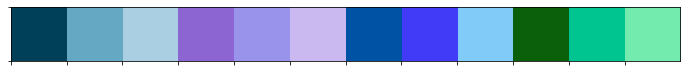

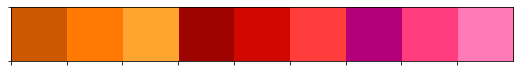

In [3]:
costume_colors_features = ['#004159', '#65A8C4', '#AACEE2', '#8C65D3', '#9A93EC', '#CAB9F1', '#0052A5', '#413BF7', '#81CBF8', '#0B610B', '#00C590', '#73EBAE']
costume_colors_metabs = ['#CC5800', '#FF7A05', '#FFA42E', '#9E0300', '#D10700', '#FF3D3D', '#B3007A', '#FF3D7E', '#FF7AB6']
sns.palplot(costume_colors_features)
plt.savefig(os.path.join(paper_dir, 'colors_features.png'), dpi=50, bbox_inches='tight')
sns.palplot(costume_colors_metabs)
plt.savefig(os.path.join(paper_dir, 'colors_metabs.png'), dpi=50, bbox_inches='tight')

super_pathway_color = {'Cofactors and Vitamins':costume_colors_metabs[0],'Peptides':costume_colors_metabs[1], 'Lipids':costume_colors_metabs[2],
                      'Amino acids':costume_colors_metabs[3], 'Energy':costume_colors_metabs[4], 'Xenobiotics':costume_colors_metabs[5],
                      'Carbohydrates':costume_colors_metabs[6], 'Nucleotides':costume_colors_metabs[7],'Unknowns':costume_colors_metabs[8]}

In [4]:
costume_colors_features = ['#004159', '#AACEE2', '#8C65D3', '#CAB9F1', '#0B610B', '#73EBAE', 'tomato']

main_hm_cols = ['Clinical data', 'Diet', 'Time of day', 'Microbiome', 'Genetics', 'Lifestyle', 'Full model']

main_features_colors = {main_hm_cols[i]:costume_colors_features[i] for i in range(len(main_hm_cols))}
main_features_colors

{'Clinical data': '#004159',
 'Diet': '#AACEE2',
 'Time of day': '#8C65D3',
 'Microbiome': '#CAB9F1',
 'Genetics': '#0B610B',
 'Lifestyle': '#73EBAE',
 'Full model': 'tomato'}

# Estimate P-value from bootstrapping

In [5]:
from scipy import stats

def _estimate_pval(est, bs, col_name, estimate_col = 'Coefficient_of_determination'):
    def r2z(r):
        return 0.5 * np.log((1 + r) / (1 - r))
    def z2r(z):
        return (np.exp(2*z) - 1) / (np.exp(2*z) + 1)
    fisher_transformed_rs = r2z(bs.astype(float)).copy()
    emp_var = fisher_transformed_rs.T.var()
    return est.astype(float).T.apply(lambda x: stats.chi2(1).sf(r2z(x)**2 / emp_var.loc[x.name])).T.rename(columns={estimate_col:col_name}), \
                pd.DataFrame(bs.T.quantile([0.025, 0.975]).apply(lambda x: (x.iloc[0], x.iloc[1]))).rename(columns={0: col_name}), \
                est.rename(columns={'Coefficient_of_determination': col_name})

In [6]:
os.listdir('../technical_noise/Grouped0.85/Bootstrapping_v2/LightGBM/')

['clinical_data',
 'commands.txt',
 'lifestyle',
 'morning',
 'MB_full',
 'MB_daphna_LONG5_s',
 'all_features',
 'diet_full']

In [7]:
main_hm_cols_dic = {'season':'Seasonal effects', 'drugs':'Drugs', 'lifestyle':'Lifestyle', 'MB_daphna_LONG5_s':'Microbiome_segata', 'ffq_diet0.01':'Diet_old', 
                    'anthropometrics':'Anthropometrics', 'macronutrients':'Macronutrients', 'cardiometabolic':'Cardiometabolic', 'age':'Age',
                   'morning':'Time of day', 'sex':'Sex', 'all_features':'Full model', 'diet_full': 'Diet', 'clinical_data': 'Clinical data', 'MB_full':'Microbiome'}

bootstrapping_dir = '../technical_noise/Grouped0.85/Bootstrapping_v2/LightGBM/'
pvalues = []
estimates = []
ci = []
r2_col = 'Coefficient_of_determination'

for col in tqdm_notebook(main_hm_cols_dic):
    if not os.path.exists(os.path.join(bootstrapping_dir, col, 'estimates.csv')):
        continue
    est = pd.read_csv(os.path.join(bootstrapping_dir, col, 'estimates.csv'), index_col=0)
    bs = pd.read_csv(os.path.join(bootstrapping_dir, col, r2_col + '.csv'), index_col=0).astype(float)
    
    pval, quantiles, estimate = _estimate_pval(est[[r2_col]], bs, col_name=main_hm_cols_dic[col])
    
    pvalues.append(pval.fillna(1))
    estimates.append(estimate)
    ci.append(quantiles)
    
pvalues = pd.concat(pvalues, axis=1, sort=True)
estimates = pd.concat(estimates, axis=1, sort=True)    
ci = pd.concat(ci, axis=1, sort=True)

pvalues.index.name, estimates.index.name, ci.index.name = 'CHEMICAL_ID', 'CHEMICAL_ID', 'CHEMICAL_ID'

pvalues.to_csv(os.path.join(curr_dir, 'pvalues.csv'))
estimates.to_csv(os.path.join(curr_dir, 'estimates.csv'))
ci.to_csv(os.path.join(curr_dir, 'ci.csv'))

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


In [7]:
pvalues = pd.read_csv(os.path.join(curr_dir, 'pvalues.csv'), index_col=0)
estimates = pd.read_csv(os.path.join(curr_dir, 'estimates.csv'), index_col=0)
ci = pd.read_csv(os.path.join(curr_dir, 'ci.csv'), index_col=0)

In [8]:
(pvalues < 0.05/(1067*6)).sum()
(pvalues < 0.05/(1067*1)).sum()

Clinical data        206
Microbiome           110
Microbiome_segata    110
Lifestyle              3
Full model           521
Time of day          161
Diet                 214
dtype: int64

# Read genetics results

In [9]:
r2_col = 'Coefficient_of_determination'
genetics_res = pd.read_csv('/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Metabolon/Genetics/CVPrediction/grouped/results.csv', index_col=0)
genetics_res['ci'] = genetics_res[[r2_col]].applymap(lambda x: (x, x+1e-6))

estimates_w_genetics = pd.concat((estimates, genetics_res[[r2_col]].rename(columns={r2_col:'Genetics'})), axis=1, sort=True).loc[:, main_hm_cols]
pvalues_w_genetics = pd.concat((pvalues, genetics_res[['pearson_p']].rename(columns={'pearson_p':'Genetics'}).fillna(1)), axis=1, sort=True).loc[:, main_hm_cols]
ci_w_genetics = pd.concat((ci, genetics_res[['ci']].rename(columns={'ci':'Genetics'})), axis=1, sort=True).loc[:, main_hm_cols]

try:
    ci_w_genetics = ci_w_genetics.applymap(lambda x: (float(re.findall(number_re, x)[0]), float(re.findall(number_re, x)[1])) if type(x) is str else x)
except:
    pass

pvalues_w_genetics[estimates_w_genetics < 0] = 1
ci_w_genetics[estimates_w_genetics < 0] = np.nan

In [10]:
print ('median max r2 including genetics', estimates_w_genetics.max(1).median())
print ('number of metabolites with r2 > 0.1 including genetics', (estimates_w_genetics.max(1) > 0.1).sum())
# estimates.max(1).median()
# (estimates.drop('Full model', axis=1).max(1) > 0.1).sum()
print ('median max r2 not including full model or genetics', estimates.drop('Full model', axis=1).max(1).median())
# (estimates['Full model'] > 0.1).sum()
# (estimates.max(1) > 0.1).sum()
# estimates.shape

median max r2 including genetics 0.10200425964704284
number of metabolites with r2 > 0.1 including genetics 543
median max r2 not including full model or genetics 0.07460558646887105


In [11]:
(pvalues_w_genetics < 0.05/(1067*1)).sum()
# (estimates_w_genetics['Genetics'] > 0.01).sum()

Clinical data    206
Diet             211
Time of day      161
Microbiome       107
Genetics          70
Lifestyle          3
Full model       521
dtype: int64

In [12]:
pd.DataFrame(fdr_correction(pvalues_w_genetics)[1] < 0.05/7).any(1).sum()

723

## save as Supplementary tables

In [13]:
pd.concat((estimates_w_genetics[main_hm_cols].rename(columns={i:i + ' R2' for i in main_hm_cols}),
                 pvalues_w_genetics[main_hm_cols].rename(columns={i:i + ' p-value' for i in main_hm_cols}),
                  ci_w_genetics[main_hm_cols].rename(columns={i:i + ' 95% CI' for i in main_hm_cols})), axis=1).sort_index(1).to_csv('Supp_table1_r2_and_pvals.csv')

# Plot

## PCA

In [14]:
def PCA_transform(data, n_components=100, fillna='floor', take_log10=True, return_pca=False):
    print ('PCA_transform')
    assert type(data) is pd.core.frame.DataFrame
    data_copy = data.copy()
    if take_log10:
        if data_copy.min().min() >= 0 and data_copy.max().max() <= 1:
            data_copy[data_copy == 0] = np.nan
            data_copy = data_copy.apply(lambda x: np.log10(x))
    if isinstance(fillna, (int, float, complex)):
        data_copy.fillna(fillna, inplace=True)
    elif fillna is min:
        data_copy.fillna(data_copy.min().min(), inplace=True)
    elif fillna == 'floor':
        data_copy.fillna(np.floor(data_copy.min().min()), inplace=True)
    pca = PCA(n_components=n_components)
    #     pca.fit_transform(data_copy)
    a_scores = pca.fit_transform(data_copy.values)
    pca_df = pd.DataFrame(a_scores, index=data_copy.index,
                          columns=['PC' + str(i + 1) for i in range(a_scores.shape[1])])
    if return_pca:
        return pca_df, pca
    else:
        return pca_df
    
n_components=400
pca_df, pca = PCA_transform(data=grouped_metabs, n_components=n_components, take_log10=False, return_pca=True)
pca_df.to_csv(os.path.join('dataframes', 'grouped_metabs_%dPCs.csv'%(n_components)))

PCA_transform


In [15]:
def _estimate_overall_explained_variance_of_PCs(full_model_results, feature_results, pca, return_all=False, max_number_of_pcs=None):
    full_model_ev, feature_ev = 0, 0
    max_pcs = max_number_of_pcs
    if max_number_of_pcs is None: max_pcs = len(pca.explained_variance_ratio_)
    
    pcs = ['PC%d'%d for d in range(1, min(max_pcs, len(pca.explained_variance_ratio_))+ 1)]
    for i, pc in zip(range(len(pcs)), pcs):
        full_model_ev += (max(0, full_model_results.loc[pc, 'Coefficient_of_determination']) * pca.explained_variance_ratio_[i])
        feature_ev += (max(0, feature_results.loc[pc, 'Coefficient_of_determination']) * pca.explained_variance_ratio_[i])
    if return_all:
        return feature_ev/full_model_ev, full_model_ev, feature_ev
    return feature_ev/full_model_ev

In [16]:
max_number_of_pcs = 400

pc400_dic = {}
for f in [f for f in os.listdir('../technical_noise/RSCV/LightGBM/') if f.startswith('grouped')]:
    feature = f.split('PCs_')[1]
    try:
        pc400_dic[feature] = pd.read_csv(os.path.join('../technical_noise/RSCV/LightGBM/', f, 'results.csv'), index_col=0)
    except:
        pass

pc400_df = pd.DataFrame(index=pc400_dic.keys(), columns=['EV relative to full model', 'EV sum'])
full_model_name = 'full_model'
for k in pc400_dic:
    relative_ev, full_model_ev, feature_ev = _estimate_overall_explained_variance_of_PCs(pc400_dic[full_model_name], pc400_dic[k], pca, return_all=True, max_number_of_pcs=max_number_of_pcs)
    pc400_df.loc[k, :] = [relative_ev, feature_ev]
    
full_model_ev_sum = [_estimate_overall_explained_variance_of_PCs(pc400_dic[full_model_name], pc400_dic[full_model_name], pca, return_all=True, max_number_of_pcs=i)[1] for i in range(1, max_number_of_pcs+1)]
    
pc400_df.rename(index={'season':'Seasonal effects', 'drugs':'Drugs', 'lifestyle':'Lifestyle', 'MB_daphna_LONG5_s':'Microbiome_segata', 'ffq_diet0.01':'Diet_old', 
                    'anthropometrics':'Anthropometrics', 'macronutrients':'Macronutrients', 'cardiometabolic':'Cardiometabolic', 'age':'Age',
                   'morning':'Time of day', 'sex':'Sex', 'all_features':'Full model', 'diet_full': 'Diet', 'clinical_data': 'Clinical data', 'MB_full':'Microbiome', 'full_model': 'Full model'}, inplace=True)
pc400_df.sort_values('EV relative to full model', ascending=False)

,EV relative to full model,EV sum
Full model,1,0.124202
ffq+diet0.05,0.491429,0.0610365
Diet,0.488962,0.06073
Clinical data,0.474666,0.0589544
Microbiome,0.307555,0.038199
MB_daphna_LONG5_S,0.298531,0.0370781
Sex,0.21032,0.0261221
Anthropometrics,0.20739,0.0257582
Cardiometabolic,0.167438,0.0207961
Age,0.160223,0.0199


0.4056347705438853


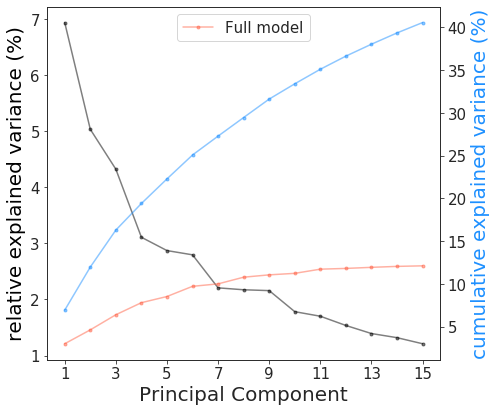

In [72]:
# max_number_of_pcs = 15

# print (pca.explained_variance_ratio_[:max_number_of_pcs].sum())
# sns.set_style('ticks')

# fig, ax1 = plt.subplots(1, 1, figsize=(7, 6))

# ax1.plot(range(1, max_number_of_pcs+1), pca.explained_variance_ratio_[:max_number_of_pcs]*100, 'o-', color='black', alpha=0.5, markersize=3)
# ax1.set_ylabel('relative explained variance (%)', color='black', fontsize=20)
# # ax.set_ylim((0, 8))
# ax1.tick_params(labelsize=15)
# ax11 = ax1.twinx()
# ax11.plot(range(1, max_number_of_pcs+1), np.cumsum(pca.explained_variance_ratio_[:max_number_of_pcs])*100, 'o-', color='dodgerblue', alpha=0.5, markersize=3)
# ax11.set_ylabel('cumulative explained variance (%)', color='dodgerblue', fontsize=20)
# # ax2.set_ylim((0, 100))
# ax11.tick_params(labelsize=15)
# if max_number_of_pcs > 100:
#     ax1.set_xscale('log')
#     ax1.set_xticks([1, 10, 100, 400])
#     ax1.set_xticklabels([1, 10, 100, 400])
# else:
#     ax1.set_xticks(range(1, max_number_of_pcs+1, 2))
# ax1.set_xlabel('Principal Component', fontsize=20)
# # full model info
# ax11.plot(range(1, max_number_of_pcs+1), np.array(full_model_ev_sum[:max_number_of_pcs])*100, 'o-', color='tomato', alpha=0.5, markersize=3, label='Full model')
# ax11.legend(loc='upper center', fontsize=15)

# fig.tight_layout()

# plt.savefig(os.path.join(curr_dir, 'Supp_PCA_over_metabolites_%dPCs_explained_variance_with_full_model.png'%max_number_of_pcs), dpi=800, bbox_inches='tight')

## a-e

In [17]:
def _ci_fix(x):
    if x == 0 or x[0]>0:
        return x
    final_x = [x[0], x[1]]
    if x[0] < 0:
        final_x[0] = 0
    if x[1] < 0:
        final_x[1] = 0
    return (final_x[0], final_x[1])

# all_CI.applymap(_ci_fix)

Clinical data    337
Diet             335
Time of day      253
Microbiome       182
Genetics          83
Lifestyle          7
Full model       714
dtype: int64


/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:245: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

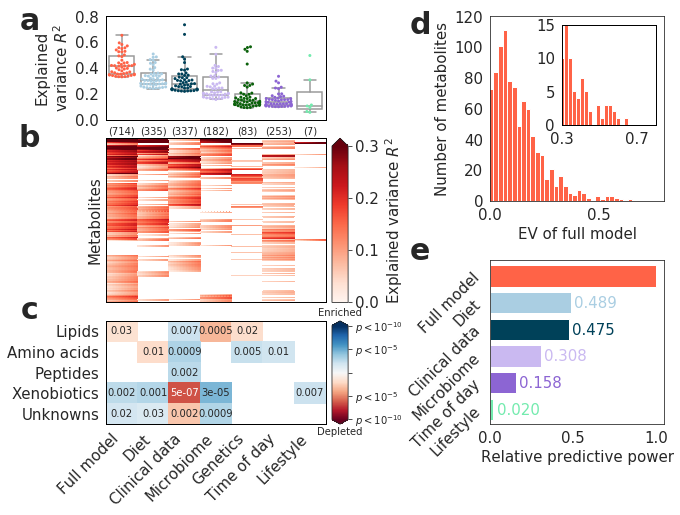

In [55]:
sns.set_style('white')
resolution = 20

zero_out = 'FDR' # 'FDR', 'BONF'
zero_out_FDR_th = 0.1

boxplot_top100 = True
order_by_median_ev = True

grouped_metabs_sp = grouped_metabs_sp.loc[pvalues.index].dropna()
for top_metabs in [50]:
    all_pvals = pvalues_w_genetics[main_hm_cols].copy()

    all_qvals = pd.DataFrame(fdr_correction(all_pvals.copy().astype(object))[1], index=all_pvals.index, columns=all_pvals.columns).copy()

    all_CI = ci_w_genetics.applymap(lambda x: (float(str(x).split(',')[0].split('(')[1]), float(str(x).split(',')[1].split(')')[0])) if type(x) == str else x)

    all_ev = estimates_w_genetics[main_hm_cols].copy()

    if zero_out == 'BONF':
        all_CI[all_pvals > 0.05/(all_pvals.shape[0])] = 0
        all_ev[all_pvals > 0.05/(all_pvals.shape[0])] = np.nan
    elif zero_out == 'BONF_all':
        all_CI[all_pvals > 0.05/(all_pvals.shape[0] * all_pvals.shape[1])] = 0
        all_ev[all_pvals > 0.05/(all_pvals.shape[0] * all_pvals.shape[1])] = np.nan
    elif zero_out == 'FDR':
        all_CI[all_qvals > zero_out_FDR_th] = 0
        all_ev[all_qvals > zero_out_FDR_th] = np.nan
    else:
        raise
        
        
    print (all_ev.notnull().sum())

    melted_ev = all_ev.copy()
    if boxplot_top100:
        for c in melted_ev.columns:
            zero_out_idx = all_ev[c].sort_values(ascending=False).tail(all_qvals.shape[0] - top_metabs).index
            melted_ev.loc[zero_out_idx, c] = np.nan

    if order_by_median_ev:
        # taking the first 50 regardless of whether there are such metabolites
        new_ordering = melted_ev.fillna(0).apply(lambda x: x.sort_values(ascending=False).head(50).median()).sort_values(ascending=False).index
#         new_ordering = melted_ev.median().sort_values(ascending=False).index
        all_pvals = all_pvals[new_ordering]
        all_qvals = all_qvals[new_ordering]
        all_CI = all_CI[new_ordering]
        all_ev = all_ev[new_ordering]

    maskvalue = (1e-6) * -1
    def open_range(x):
        if x == 0:
            return [maskvalue]*(resolution+1)
        try:
            return np.arange(x[0], x[1]+(x[1]-x[0])/(resolution+1), (x[1]-x[0])/resolution)[:resolution+1]
        except:
            return x[0]*(resolution+1)

    all_CI_bars = all_CI.fillna(0).applymap(open_range)

    all_CI_cnct = pd.DataFrame()
    for c in tqdm_notebook(all_CI_bars.columns):
        all_CI_cnct = pd.concat((all_CI_cnct, all_CI_bars[c].apply(pd.Series)), axis=1)

    all_CI_cnct = all_CI_cnct.loc[~(all_CI_cnct == maskvalue).all(axis=1)]

    super_pathway_for_df = ['Lipids', 'Amino acids', 'Peptides', 'Xenobiotics', 'Unknowns']

    mw_superpathway_df = pd.DataFrame(index=grouped_metabs_sp.SUPER_PATHWAY.value_counts().index, columns=all_pvals.columns).loc[super_pathway_for_df]
    mw_superpathway_df_q = pd.DataFrame(index=grouped_metabs_sp.SUPER_PATHWAY.value_counts().index, columns=all_pvals.columns).loc[super_pathway_for_df]

    for sp in mw_superpathway_df.index:
        metabs_in_sp = grouped_metabs_sp[grouped_metabs_sp.SUPER_PATHWAY == sp].CHEMICAL_ID.astype(str)
        metabs_notin_sp = grouped_metabs_sp[grouped_metabs_sp.SUPER_PATHWAY != sp].CHEMICAL_ID.astype(str)
        for col in mw_superpathway_df.columns:
            # right side are metabolites not in the pathway
            # t is positive -> right side is bigger -> metabolites in pathway has lower p-values -> pathway is enriched for that feature
            try:
                t, p = directed_mannwhitneyu(all_pvals.reindex(all_ev.dropna(how='all').index, axis=0).reindex(metabs_in_sp, axis=0)[col].dropna(), 
                                             all_pvals.reindex(all_ev.dropna(how='all').index, axis=0).reindex(metabs_notin_sp, axis=0)[col].dropna())
            except:
                t, p = 1, 0.5
            # t is positive -> -log10(p)*sign(t) is positive
            mw_superpathway_df.loc[sp, col] = np.log10(p) * np.sign(t) * -1
            mw_superpathway_df_q.loc[sp, col] = p
    mw_superpathway_df_q.loc[:, :] = fdr_correction(mw_superpathway_df_q)[1]
    mw_superpathway_df[mw_superpathway_df_q > zero_out_FDR_th] = None
    mw_superpathway_df = mw_superpathway_df.loc[super_pathway_for_df]

    oos_all_ev = all_ev.copy()
    oos_all_pval = all_pvals.copy()

    labels_fontsize = 20
    tick_fontsize = 15
    temp_data = (all_CI_cnct.astype(float).fillna(0) - maskvalue).copy()

    cg = sns.clustermap(temp_data, xticklabels=False, yticklabels=False, col_cluster=False)
    plt.clf()
    
    corr = estimates_w_genetics[main_hm_cols].corr('spearman')
    cg1 = sns.clustermap(corr, xticklabels=False, yticklabels=False)
    plt.clf()
    corr_clust = corr.iloc[cg1.dendrogram_row.reordered_ind, cg1.dendrogram_col.reordered_ind]
    corr = corr.loc[new_ordering, new_ordering]

    fig = plt.figure(figsize=(10, 7.5))

    gs = gridspec.GridSpec(21, 25, wspace=.4, hspace=10.)

    main_heatmap = fig.add_subplot(gs[6:15, :10])

    # define costume colormap
    colors1 = plt.cm.Greys(np.linspace(0., 1, 512))[:256]
    colors2 = plt.cm.Reds(np.linspace(0, 1, 256))
    # combine them and build a new colormap
    colors = np.vstack((colors1, colors2))
    mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

    sns.heatmap(temp_data.iloc[cg.dendrogram_row.reordered_ind, :].clip(upper=0.3), 
                xticklabels=False, yticklabels=False, ax=main_heatmap, cbar=False, cmap='Reds', #cmap=mymap,
                mask=temp_data.iloc[cg.dendrogram_row.reordered_ind, :] == 0) #cbar_kws={'label': 'Spearman R'}
    main_heatmap.set_ylabel('Metabolites', fontsize=tick_fontsize)

    # add the arrows to ylabel
    ylim = main_heatmap.get_ylim()
    main_heatmap.annotate('', xy=(-3, ylim[1]), xytext=(-3, ylim[1] - (ylim[1] * 0.35)),
                arrowprops=dict(facecolor='black', shrink=0.05), annotation_clip=False)
    main_heatmap.annotate('', xy=(-3, 0), xytext=(-3, ylim[1] * 0.35),
                arrowprops=dict(facecolor='black', shrink=0.05), annotation_clip=False)


    for _, spine in main_heatmap.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
        spine.set_color('black')

    main_heatmap_cbar = fig.add_subplot(gs[6:15, 10])
    norm1 = mpl.colors.Normalize(vmin=0, vmax=0.3)
    cb1 = mpl.colorbar.ColorbarBase(main_heatmap_cbar, cmap=plt.cm.Reds,
                                    norm=norm1, extend='max', ticks=[0, 0.1, 0.2, 0.3])
    cb1.set_label('Explained variance ' + r'$R^2$')
    cb1.ax.tick_params(labelsize=tick_fontsize)
    cb1.ax.yaxis.label.set_size(tick_fontsize)

    # top boxplots
    top_boxplots = fig.add_subplot(gs[:6, :10])
    melted_ev = all_ev.copy()
    if boxplot_top100:
        for c in melted_ev.columns:
            zero_out_idx = all_ev[c].sort_values(ascending=False).tail(all_qvals.shape[0] - top_metabs).index
            melted_ev.loc[zero_out_idx, c] = np.nan

    melted_ev = pd.melt(melted_ev)
    darkred = sns.color_palette('Reds')[-3]
    sns.boxplot(data=melted_ev, x='variable', y='value', ax=top_boxplots, palette=['white' for c in all_ev.columns], showfliers=False)
    sns.swarmplot(data=melted_ev, x='variable', y='value', ax=top_boxplots, palette=[main_features_colors[c] for c in all_ev.columns], size=3)
    top_boxplots.tick_params(labelsize=tick_fontsize)
    top_boxplots.set_xlabel('')
    ylim=0.8
    top_boxplots.set_ylim((0, ylim))
    top_boxplots.set_yticks(np.arange(0, ylim+0.1, 0.2))
    top_boxplots.set_xticklabels([])
    top_boxplots.set_xticklabels(['(%d)'%all_ev[c].notnull().sum() for c in all_ev.columns], fontsize=tick_fontsize-5)
    top_boxplots.set_ylabel('Explained\nvariance ' + r'$R^2$', fontsize=tick_fontsize)

    for _, spine in top_boxplots.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
        spine.set_color('black')

    bottom_heatmap = fig.add_subplot(gs[15:, :10])

    sns.heatmap(mw_superpathway_df.astype(float).clip(upper=10).clip(lower=-10), mask=mw_superpathway_df == 0, cmap=plt.cm.RdBu, 
                annot=mw_superpathway_df.astype(float).apply(lambda x: 10**(abs(x) * -1)), fmt='0.1g', vmin=-10, vmax=10,
                ax=bottom_heatmap, 
                annot_kws={'size':tick_fontsize-5}, cbar=False)
    bottom_heatmap.set_xticklabels(bottom_heatmap.get_xticklabels(), rotation=45, fontsize=tick_fontsize, horizontalalignment='right')
    bottom_heatmap.set_yticklabels(bottom_heatmap.get_yticklabels(), rotation=0, fontsize=tick_fontsize)
    bottom_heatmap_cbar = fig.add_subplot(gs[15:, 10])
    norm2 = mpl.colors.Normalize(vmin=-10, vmax=10)
    cb2 = mpl.colorbar.ColorbarBase(bottom_heatmap_cbar, cmap=plt.cm.RdBu, norm=norm2, extend='both', ticks=[-10, -5, 0, 5, 10]) #  ticks=[-10, -5, 0, 5, 10]
    cb2.ax.tick_params(labelsize=tick_fontsize-5)
    cb2.ax.set_yticklabels(['$p<10^{-10}$', '$p<10^{-5}$', '', '$p<10^{-5}$', '$p<10^{-10}$'])
    cb2.ax.yaxis.label.set_size(tick_fontsize)
    
    plt.text(0.5, 1.08, 'Enriched', ha='center', va='center', transform=bottom_heatmap_cbar.transAxes, fontsize=tick_fontsize-5)
    plt.text(0.5, -0.08, 'Depleted', ha='center', va='center', transform=bottom_heatmap_cbar.transAxes, fontsize=tick_fontsize-5)

    for _, spine in bottom_heatmap.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
        spine.set_color('black')
        
    ax_D = fig.add_subplot(gs[:10, 17:])
    ax_E = fig.add_subplot(gs[12:, 17:])

    ax_D.hist(estimates_w_genetics['Full model'], bins=40, color='tomato', edgecolor='white')
    ax_D .tick_params(labelsize=tick_fontsize)
    ax_D .set_xlabel('EV of full model', fontsize=tick_fontsize)
    ax_D .set_ylabel('Number of metabolites', fontsize=tick_fontsize)
    # legend
    ax_D .set_ylim((0, 120))
    ax_D .set_xlim((0, 0.8))
    from mpl_toolkits.axes_grid.inset_locator import inset_axes
    inset_axes = inset_axes(ax_D ,
                        width="55%", # width = 30% of parent_bbox
                        height="55%", # height : 1 inch
                        bbox_to_anchor=(0., 0., .98, .98), bbox_transform=ax_D .transAxes)

    for _, spine in inset_axes.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1.)
        spine.set_color('black')
    inset_axes.hist(estimates_w_genetics['Full model'], bins=40, color='tomato', edgecolor='white')
    inset_axes.set_xlim((0.3, 0.8))
    inset_axes.set_xticks([0.3, 0.7])
    inset_axes.set_ylim((0, 15))
    inset_axes.tick_params(labelsize=tick_fontsize)
    inset_axes.set_yticks(range(0, 16, 5))

    mask = np.zeros_like(corr_clust, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    corr_clust = corr_clust.iloc[1:, :-1]
    corr = corr.iloc[1:, :-1]
    mask = mask[1:, :-1]
   
    d = main_features_colors.copy()
    d.update({'Full model': 'tomato'})
    relevant_pc_400_df = pc400_df.reindex(d.keys(), axis=0).dropna()
    relevant_pc_400_df.sort_values('EV relative to full model', ascending=False, inplace=True)
    cols = []
    for col, i in zip(relevant_pc_400_df.index, range(relevant_pc_400_df.shape[0], 0, -1)):
        if col not in d:
            continue
        cols.append(col)
        ax_E.barh([i + 0.4], relevant_pc_400_df.loc[col, 'EV relative to full model'], color=d[col], label=col, alpha=1) 
        if col != 'Full model':
            ax_E.text(relevant_pc_400_df.loc[col, 'EV relative to full model'] + 0.02, i + 0.2, '%0.3f'%relevant_pc_400_df.loc[col, 'EV relative to full model'] , fontsize=tick_fontsize, color=d[col])
    ax_E.set_yticks(np.array(range(len(cols), 0, -1)) + 0.4)
    ax_E.set_yticklabels(cols, rotation=45)
    ax_E.set_ylim((0.85, len(cols)+1))
    ax_E.tick_params(labelsize=tick_fontsize)
    ax_E.set_xlabel('Relative predictive power', fontsize=tick_fontsize) 

    fig.tight_layout()
    
    plt.text(-0.35, 0.95, 'a', ha='center', va='center', transform=top_boxplots.transAxes, fontsize=30, weight='bold')
    plt.text(-0.35, 1, 'b', ha='center', va='center', transform=main_heatmap.transAxes, fontsize=30, weight='bold')
    plt.text(-0.35, 1.1, 'c', ha='center', va='center', transform=bottom_heatmap.transAxes, fontsize=30, weight='bold')
    plt.text(-0.4, 0.95, 'd', ha='center', va='center', transform=ax_D.transAxes, fontsize=30, weight='bold')
    plt.text(-0.4, 1.05, 'e', ha='center', va='center', transform=ax_E.transAxes, fontsize=30, weight='bold')

if zero_out == 'FDR':
    plt.savefig(os.path.join(curr_dir, 'Figure1_FDR%0.2f_small.png'%(zero_out_FDR_th)), dpi=300, bbox_inches='tight')
    plt.savefig(os.path.join(curr_dir, 'Figure1_FDR%0.2f.png'%(zero_out_FDR_th)), dpi=1000, bbox_inches='tight')
    plt.savefig(os.path.join(curr_dir, 'Figure1_FDR%0.2f.pdf'%(zero_out_FDR_th)), dpi=1000, bbox_inches='tight')
# else:
#     plt.savefig(os.path.join(curr_dir, '2b-f_%s_small.png'%(zero_out)), dpi=200, bbox_inches='tight')
#     plt.savefig(os.path.join(curr_dir, '2b-f_%s.png'%(zero_out)), dpi=1200, bbox_inches='tight')

### merge pca+correlation with diet-mb comparison+X-16124

In [30]:
# combine all features
mb_ot_res = pd.read_csv('../technical_noise/RSCV/LightGBM/metabolomics_shap_ot0.05_MB_daphna_LONG5_S/results.csv', index_col=0).sort_index()
diet_ot_res = pd.read_csv('../technical_noise/RSCV/LightGBM/metabolomics_shap_ot0.05_ffq+diet0.05/results.csv', index_col=0).sort_index()
mb_diet_ot_res = pd.read_csv('../technical_noise/RSCV/LightGBM/metabolomics_shap_ot0.05_mb_diet/results.csv', index_col=0).sort_index()
# compute max of microbiome and diet
max_ot_res = pd.concat((mb_ot_res['Coefficient_of_determination'], diet_ot_res['Coefficient_of_determination']), axis=1, sort=True).max(1)

permuted_resutls = pd.read_csv('../technical_noise/RSCV/LightGBM/metabolomics_shap_ot0.05_mb-permuted_diet/results.csv', index_col=0).sort_index()
mb_full_abs_shap = pd.read_csv('/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Metabolon/technical_noise/RSCV/LightGBM/metabolomics_MB_daphna_LONG5_S/abs_shap.csv', index_col=0)
mb_full = pd.read_csv('dataframes/mar17_daphna_LONG5_s.csv', index_col=0)

def _find_closest_ancestry(tax, tax_level_return='s'):
    best_tax = 'unknown'
    for level in ['k', 'p', 'c', 'o', 'f', 'g', 's']:
        if tax.split(level + '__')[1].startswith('unknown'): break
        best_tax = ' '.join(tax.split(level + '__')[1].split('|')[0].split('_')) + ' (' + level + ')'
    sgb_num = re.findall('\d+', tax.split(tax_level_return + 'SGB')[1].split('|')[0])[0]
    if best_tax == 'unknown': best_tax += ' - ' + str(sgb_num)
    return best_tax, sgb_num

0.9924405333017519


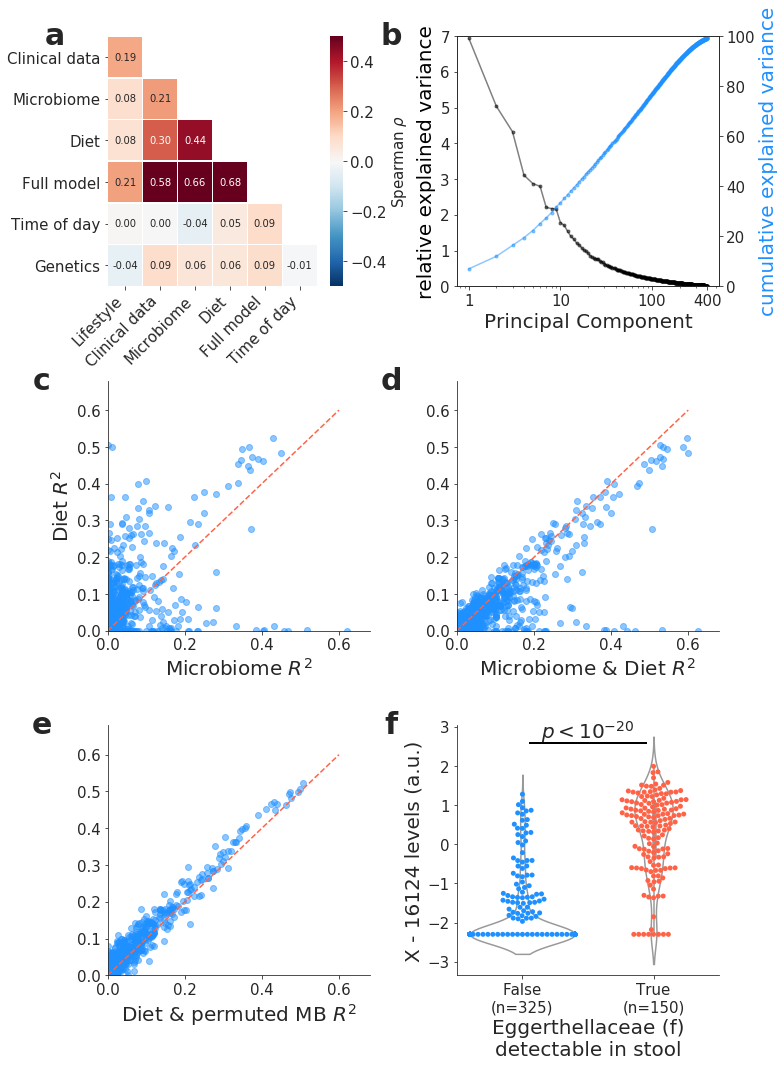

In [35]:
fig, axes  = plt.subplots(3, 2, figsize=(11, 15))

ax = axes[0, 0]
ax = sns.heatmap(corr_clust, mask=mask, linewidths=0.5, center=0, annot=True, fmt='0.2f', annot_kws={'size':10}, ax=ax,
                                      cbar_kws={'label': r'Spearman $\rho$'}, cmap=plt.cm.RdBu_r, vmin=-0.5, vmax=0.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.tick_params(labelsize=tick_fontsize)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=tick_fontsize)
cbar.ax.set_ylabel(r'Spearman $\rho$', fontsize=tick_fontsize)

print (pca.explained_variance_ratio_.sum())
sns.set_style('ticks')

ax = axes[0, 1]
ax.plot(range(1, 401), pca.explained_variance_ratio_*100, 'o-', color='black', alpha=0.5, markersize=3)
ax.set_xscale('log')
ax.set_ylabel('relative explained variance', color='black', fontsize=20)
ax.set_ylim((0, 7))
ax.tick_params(labelsize=15)
ax2 = ax.twinx()
ax2.plot(range(1, 401), np.cumsum(pca.explained_variance_ratio_)*100, 'o-', color='dodgerblue', alpha=0.5, markersize=3)
ax2.set_ylabel('cumulative explained variance', color='dodgerblue', fontsize=20)
ax2.set_ylim((0, 100))
ax2.tick_params(labelsize=15)

ax.set_xticks([1, 10, 100, 400])
ax.set_xticklabels([1, 10, 100, 400])
ax.set_xlabel('Principal Component', fontsize=20)

# axes[0, 2].axis('off')

ax = axes[1, 0]
ax.plot(mb_ot_res['Coefficient_of_determination'].clip(lower=0.0), 
        diet_ot_res['Coefficient_of_determination'].clip(lower=0.0), 
        'o', alpha=0.5, color='dodgerblue')
ax.plot([0, 0.6], [0, 0.6], '--', color='tomato')
ax.set_xlim([0, 0.68])
ax.set_ylim([0, 0.68])
ax.tick_params(labelsize=tick_fontsize)
ax.set_xlabel('Microbiome $R^2$', fontsize=labels_fontsize)
ax.set_ylabel('Diet $R^2$', fontsize=labels_fontsize)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# diet vs diet & MB
ax = axes[1, 1]
th = 0.01
at_least_1_over_01 = (mb_diet_ot_res['Coefficient_of_determination'] > th ) | (diet_ot_res.loc[mb_diet_ot_res.index, 'Coefficient_of_determination'] > th)
ax.plot(mb_diet_ot_res.loc[at_least_1_over_01, 'Coefficient_of_determination'].clip(lower=0.0), 
        diet_ot_res.loc[at_least_1_over_01, 'Coefficient_of_determination'].clip(lower=0.0), 
        'o', alpha=0.5, color='dodgerblue')
ax.plot([0, 0.6], [0, 0.6], '--', color='tomato')
ax.set_xlim([0, 0.68])
ax.set_ylim([0, 0.68])
ax.tick_params(labelsize=tick_fontsize)
ax.set_xlabel('Microbiome & Diet $R^2$', fontsize=labels_fontsize)
# ax.set_ylabel('Diet $R^2$', fontsize=labels_fontsize)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# diet vs diet & MB
ax = axes[2, 0]
th = 0.01
at_least_1_over_01 = (mb_diet_ot_res['Coefficient_of_determination'] > th ) | (diet_ot_res.loc[permuted_resutls.index, 'Coefficient_of_determination'] > th)
ax.plot(permuted_resutls.loc[at_least_1_over_01, 'Coefficient_of_determination'].clip(lower=0.0), 
        diet_ot_res.loc[at_least_1_over_01, 'Coefficient_of_determination'].clip(lower=0.0), 
        'o', alpha=0.5, color='dodgerblue')
ax.plot([0, 0.6], [0, 0.6], '--', color='tomato')
ax.set_xlim([0, 0.68])
ax.set_ylim([0, 0.68])
ax.tick_params(labelsize=tick_fontsize)
ax.set_xlabel('Diet & permuted MB $R^2$', fontsize=labels_fontsize)
# ax.set_ylabel('Diet $R^2$', fontsize=labels_fontsize)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# X - 16124
ax = axes[2, 1]
c = 'X - 16124'
k = mb_full_abs_shap.loc[c].sort_values().tail(1).head(1).index.values[0]
boxplot_df = pd.DataFrame(columns=['metabolite', 'bacteria'])
boxplot_df.bacteria = (mb_full.reindex(single_metabs.index, axis=0)[k] > mb_full.reindex(single_metabs.index, axis=0)[k].min()).astype(int)
boxplot_df.metabolite = single_metabs[c].copy()
sns.violinplot(x='bacteria', y='metabolite', data=boxplot_df, color='white', ax=ax)
sns.swarmplot(x='bacteria', y='metabolite', data=boxplot_df, palette=['dodgerblue', 'tomato'], ax=ax)
ax.tick_params(labelsize=tick_fontsize)
best_bac = _find_closest_ancestry(k)[0]
ax.set_xlabel(best_bac + '\ndetectable in stool', fontsize=labels_fontsize)
ax.set_ylabel(c + ' levels (a.u.)', fontsize=labels_fontsize)
ax.set_xticklabels(['False\n(n=%0.1d)'%((boxplot_df.bacteria == 0).sum()), 'True\n(n=%0.1d)'%((boxplot_df.bacteria == 1).sum())], fontsize=tick_fontsize)
# add_text_at_corner(ax, '$p<10^{-20}$', 'top left', fontsize=labelsize)
ax.text(0.5, 2.7,  '$p<10^{-20}$', ha='center', fontsize=labels_fontsize)
ax.hlines(y=2.6, xmin=0.05, xmax=0.95, linewidth=2, color='black')
# ax.text(0.5, 2.7,  '***', ha='center', fontsize=labelsize, color='red')
# ax.hlines(y=2.6, xmin=0.05, xmax=0.95, linewidth=2, color='red')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.tight_layout()
plt.text(-0.25, 1., 'a', ha='center', va='center', transform=axes[0, 0].transAxes, fontsize=30, weight='bold')
plt.text(-0.25, 1., 'b', ha='center', va='center', transform=axes[0, 1].transAxes, fontsize=30, weight='bold')
plt.text(-0.25, 1., 'c', ha='center', va='center', transform=axes[1, 0].transAxes, fontsize=30, weight='bold')
plt.text(-0.25, 1., 'd', ha='center', va='center', transform=axes[1, 1].transAxes, fontsize=30, weight='bold')
plt.text(-0.25, 1., 'e', ha='center', va='center', transform=axes[2, 0].transAxes, fontsize=30, weight='bold')
plt.text(-0.25, 1., 'f', ha='center', va='center', transform=axes[2, 1].transAxes, fontsize=30, weight='bold')

plt.savefig(os.path.join(paper_dir, 'Extended_Data_Figure5_small.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(paper_dir, 'Extended_Data_Figure5.png'), dpi=1000, bbox_inches='tight')
plt.savefig(os.path.join(paper_dir, 'Extended_Data_Figure5.pdf'), dpi=1000, bbox_inches='tight')

### Extended Data Fig. 5

In [36]:
mar17_stool_info = pd.read_csv('dataframes/mar17_stool_info.csv', index_col=0)
may18_stool_info = pd.read_csv('dataframes/may18_stool_info.csv', index_col=0)
mar17_features = pd.read_csv('dataframes/mar17_features.csv', index_col=0)
metabs1 = pd.read_csv('dataframes/metabs1.csv', index_col=0)

grouped_metabs = pd.read_csv('../technical_noise/dataframes/mar17_metabolomics_grouped085_unnormed_fillna_min_dayfromfirstsample_regressed_rzs.csv', index_col=0)
single_metabs = pd.read_csv('../technical_noise/dataframes/mar17_metabolomics_unnormed_fillna_min_dayfromfirstsample_regressed_rzs.csv', index_col=0)
grouped_metabs_sp = pd.read_csv('../technical_noise/dataframes/mar17_metabolomics_grouped085_unnormed_fillna_min_dayfromfirstsample_regressed_metabs.csv', index_col=0).loc[grouped_metabs.columns]
grouped_metabs_sp = grouped_metabs_sp.replace({'Lipid':'Lipids', 'Nucleotide':'Nucleotides', 'Amino Acid':'Amino acids', 'Peptide':'Peptides', 
                                               'Xenobiotic':'Xenobiotics', 'Unknown':'Unknowns', 'Carbohydrate':'Carbohydrates'})

s1 = pd.read_excel('/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Metabolon/BMI_paper/1-s2.0-S1550413118306302-mmc2.xlsx')
s1 = s1[s1['49 definitive BMI-associated metabolites'] == 1]
s1 = s1[['Metabolite ID', 'direction of effect', 'Mean r2']]
s1['res'] = [1*s1.loc[s, 'Mean r2'] if s1.loc[s, 'direction of effect'] == 'pos' else -1*s1.loc[s, 'Mean r2'] for s in s1.index]

s2 = pd.concat((single_metabs, mar17_features[['BMI']]), axis=1).dropna()
bmi_corr = [pearsonr(s2[s], s2['BMI'])[0] if s in metabs1.CHEMICAL_ID.values else np.nan for s in s1['Metabolite ID'].astype(str)]
# bmi_corr = [np.sign(b) * b**2 for b in bmi_corr]
s1['BMI_corr'] = [np.sign(b) * b**2 for b in bmi_corr]

In [66]:
r, p = pearsonr(s1[['BMI_corr', 'res']].dropna()['BMI_corr'], s1[['BMI_corr', 'res']].dropna()['res'])
('%0.1g'%p)

'7e-11'

0.9924405333017519


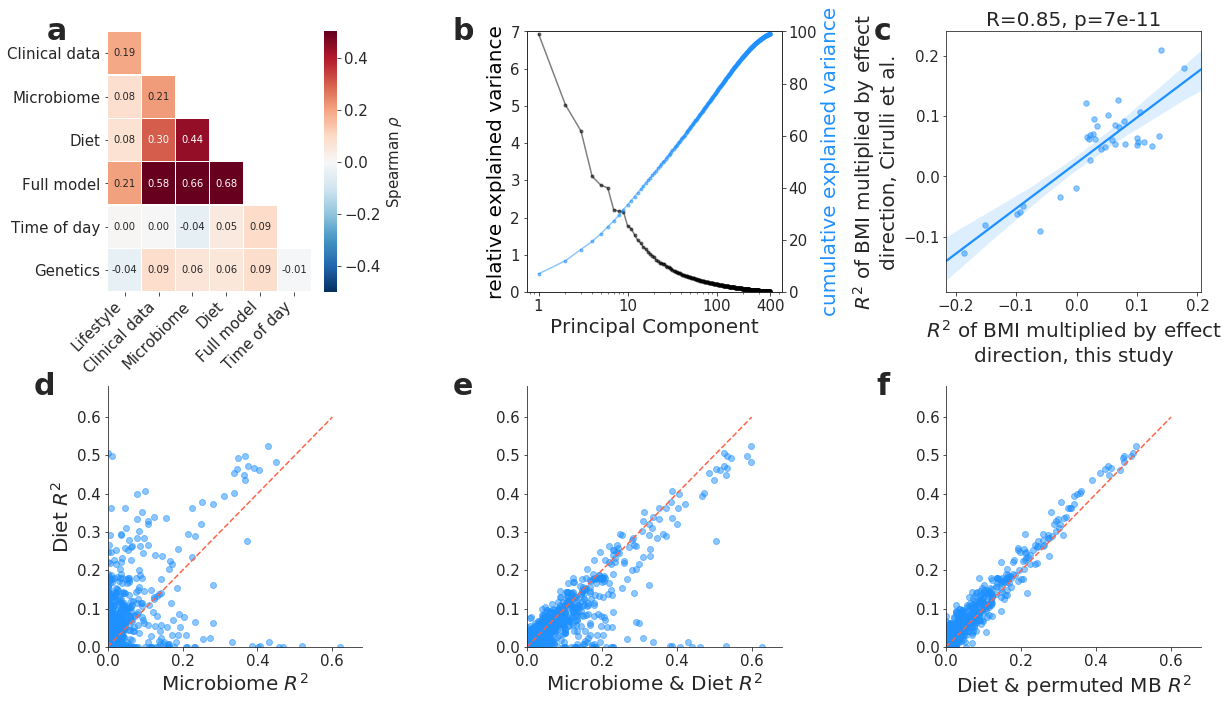

In [68]:
fig, axes  = plt.subplots(2, 3, figsize=(17, 10))

ax = axes[0, 0]
ax = sns.heatmap(corr_clust, mask=mask, linewidths=0.5, center=0, annot=True, fmt='0.2f', annot_kws={'size':10}, ax=ax,
                                      cbar_kws={'label': r'Spearman $\rho$'}, cmap=plt.cm.RdBu_r, vmin=-0.5, vmax=0.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.tick_params(labelsize=tick_fontsize)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=tick_fontsize)
cbar.ax.set_ylabel(r'Spearman $\rho$', fontsize=tick_fontsize)

print (pca.explained_variance_ratio_.sum())
sns.set_style('ticks')

ax = axes[0, 1]
ax.plot(range(1, 401), pca.explained_variance_ratio_*100, 'o-', color='black', alpha=0.5, markersize=3)
ax.set_xscale('log')
ax.set_ylabel('relative explained variance', color='black', fontsize=labels_fontsize)
ax.set_ylim((0, 7))
ax.tick_params(labelsize=tick_fontsize)
ax2 = ax.twinx()
ax2.plot(range(1, 401), np.cumsum(pca.explained_variance_ratio_)*100, 'o-', color='dodgerblue', alpha=0.5, markersize=3)
ax2.set_ylabel('cumulative explained variance', color='dodgerblue', fontsize=labels_fontsize)
ax2.set_ylim((0, 100))
ax2.tick_params(labelsize=tick_fontsize)

ax.set_xticks([1, 10, 100, 400])
ax.set_xticklabels([1, 10, 100, 400])
ax.set_xlabel('Principal Component', fontsize=labels_fontsize)

# axes[0, 2].axis('off')
ax = axes[0, 2]
sns.regplot(s1[['BMI_corr', 'res']].dropna()['BMI_corr'], s1[['BMI_corr', 'res']].dropna()['res'], ax=ax, scatter_kws={'s':30, 'alpha':0.5, 'color':'dodgerblue'}, color='dodgerblue')
r, p = pearsonr(s1[['BMI_corr', 'res']].dropna()['BMI_corr'], s1[['BMI_corr', 'res']].dropna()['res'])
# ax.set_title('R=%0.2f, p<10$^{%0.2d}$'%(r, p_base10(p)), fontsize=labels_fontsize)
ax.set_title('R=%0.2f, p=%0.1g'%(r, p), fontsize=labels_fontsize)
# p_val_str = ('%0.1g'%p)[0]
# ax.set_title('R=%0.2f, p=%0.1g'%(r, p), fontsize=labels_fontsize)


ax.tick_params(labelsize=tick_fontsize)
ax.set_xlabel(r'$R^2$' + ' of BMI multiplied by effect\ndirection, this study', fontsize=labels_fontsize)
ax.set_ylabel(r'$R^2$' + ' of BMI multiplied by effect\ndirection, Cirulli et al.', fontsize=labels_fontsize)

ax = axes[1, 0]
ax.plot(mb_ot_res['Coefficient_of_determination'].clip(lower=0.0), 
        diet_ot_res['Coefficient_of_determination'].clip(lower=0.0), 
        'o', alpha=0.5, color='dodgerblue')
ax.plot([0, 0.6], [0, 0.6], '--', color='tomato')
ax.set_xlim([0, 0.68])
ax.set_ylim([0, 0.68])
ax.tick_params(labelsize=tick_fontsize)
ax.set_xlabel('Microbiome $R^2$', fontsize=labels_fontsize)
ax.set_ylabel('Diet $R^2$', fontsize=labels_fontsize)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# diet vs diet & MB
ax = axes[1, 1]
th = 0.01
at_least_1_over_01 = (mb_diet_ot_res['Coefficient_of_determination'] > th ) | (diet_ot_res.loc[mb_diet_ot_res.index, 'Coefficient_of_determination'] > th)
ax.plot(mb_diet_ot_res.loc[at_least_1_over_01, 'Coefficient_of_determination'].clip(lower=0.0), 
        diet_ot_res.loc[at_least_1_over_01, 'Coefficient_of_determination'].clip(lower=0.0), 
        'o', alpha=0.5, color='dodgerblue')
ax.plot([0, 0.6], [0, 0.6], '--', color='tomato')
ax.set_xlim([0, 0.68])
ax.set_ylim([0, 0.68])
ax.tick_params(labelsize=tick_fontsize)
ax.set_xlabel('Microbiome & Diet $R^2$', fontsize=labels_fontsize)
# ax.set_ylabel('Diet $R^2$', fontsize=labels_fontsize)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# diet vs diet & MB
ax = axes[1, 2]
th = 0.01
at_least_1_over_01 = (mb_diet_ot_res['Coefficient_of_determination'] > th ) | (diet_ot_res.loc[permuted_resutls.index, 'Coefficient_of_determination'] > th)
ax.plot(permuted_resutls.loc[at_least_1_over_01, 'Coefficient_of_determination'].clip(lower=0.0), 
        diet_ot_res.loc[at_least_1_over_01, 'Coefficient_of_determination'].clip(lower=0.0), 
        'o', alpha=0.5, color='dodgerblue')
ax.plot([0, 0.6], [0, 0.6], '--', color='tomato')
ax.set_xlim([0, 0.68])
ax.set_ylim([0, 0.68])
ax.tick_params(labelsize=tick_fontsize)
ax.set_xlabel('Diet & permuted MB $R^2$', fontsize=labels_fontsize)
# ax.set_ylabel('Diet $R^2$', fontsize=labels_fontsize)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# X - 16124
# ax = axes[0, 2]
# c = 'X - 16124'
# k = mb_full_abs_shap.loc[c].sort_values().tail(1).head(1).index.values[0]
# boxplot_df = pd.DataFrame(columns=['metabolite', 'bacteria'])
# boxplot_df.bacteria = (mb_full.reindex(single_metabs.index, axis=0)[k] > mb_full.reindex(single_metabs.index, axis=0)[k].min()).astype(int)
# boxplot_df.metabolite = single_metabs[c].copy()
# sns.violinplot(x='bacteria', y='metabolite', data=boxplot_df, color='white', ax=ax)
# sns.swarmplot(x='bacteria', y='metabolite', data=boxplot_df, palette=['dodgerblue', 'tomato'], ax=ax)
# ax.tick_params(labelsize=tick_fontsize)
# best_bac = _find_closest_ancestry(k)[0]
# ax.set_xlabel(best_bac + '\ndetectable in stool', fontsize=labels_fontsize)
# ax.set_ylabel(c + ' levels (a.u.)', fontsize=labels_fontsize)
# ax.set_xticklabels(['False\n(n=%0.1d)'%((boxplot_df.bacteria == 0).sum()), 'True\n(n=%0.1d)'%((boxplot_df.bacteria == 1).sum())], fontsize=tick_fontsize)
# # add_text_at_corner(ax, '$p<10^{-20}$', 'top left', fontsize=labelsize)
# ax.text(0.5, 2.7,  '$p<10^{-20}$', ha='center', fontsize=labels_fontsize)
# ax.hlines(y=2.6, xmin=0.05, xmax=0.95, linewidth=2, color='black')
# # ax.text(0.5, 2.7,  '***', ha='center', fontsize=labelsize, color='red')
# # ax.hlines(y=2.6, xmin=0.05, xmax=0.95, linewidth=2, color='red')
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)

fig.tight_layout()
plt.text(-0.25, 1., 'a', ha='center', va='center', transform=axes[0, 0].transAxes, fontsize=30, weight='bold')
plt.text(-0.25, 1., 'b', ha='center', va='center', transform=axes[0, 1].transAxes, fontsize=30, weight='bold')
plt.text(-0.25, 1., 'c', ha='center', va='center', transform=axes[0, 2].transAxes, fontsize=30, weight='bold')
plt.text(-0.25, 1., 'd', ha='center', va='center', transform=axes[1, 0].transAxes, fontsize=30, weight='bold')
plt.text(-0.25, 1., 'e', ha='center', va='center', transform=axes[1, 1].transAxes, fontsize=30, weight='bold')
plt.text(-0.25, 1., 'f', ha='center', va='center', transform=axes[1, 2].transAxes, fontsize=30, weight='bold')

plt.savefig(os.path.join(paper_dir, 'Extended_Data_Figure5_small.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(paper_dir, 'Extended_Data_Figure5.png'), dpi=1000, bbox_inches='tight')
plt.savefig(os.path.join(paper_dir, 'Extended_Data_Figure5.pdf'), dpi=1000, bbox_inches='tight')

## numbers

In [127]:
print ('metabs over 10% for all features including genetics:', (all_ev.max(1) > 0.1).sum())
print ('metabs over 10% using only the full model:', (all_ev['Full model'] > 0.1).sum())
print ('median e.v. of the full model:', all_ev['Full model'].median())
print ('median e.v. without the full model:', all_ev.drop('Full model', axis=1).max(1).median())
print ('median e.v. without genetics:', all_ev.drop('Genetics', axis=1).max(1).median())
print ('median e.v. of max:', all_ev.max(1).median())

print ('fraction of sig pred, over all:', all_ev.dropna(how='all').shape[0] / all_ev.shape[0])
print ('fraction of sig pred, over Full model:', all_ev['Full model'].dropna().shape[0] / all_ev.shape[0])
print ('fraction of sig pred, over Full model and genetics:', all_ev[['Full model', 'Genetics']].dropna(how='all').shape[0] / all_ev.shape[0])
# all_ev.dropna(how='all').shape[0] / all_ev.shape[0]
# all_ev.dropna(how='all').shape[0] / all_ev.shape[0]

metabs over 10% for all features: 539
metabs over 10%: 460
median e.v. of the full model: 0.16734968517442872
median e.v. without the full model: 0.14874490662266127
median e.v. without genetics: 0.1619129160150498
median e.v. of max: 0.16194128313943834
fraction of sig pred, over all: 0.5970009372071228
fraction of sig pred, over Full model: 0.48828491096532334
fraction of sig pred, over Full model and genetics: 0.5342080599812559


In [159]:
print ('metabs over 10% for all features including genetics:', (all_ev.max(1) > 0.1).sum())
print ('metabs over 10% using only the full model:', (all_ev['Full model'] > 0.1).sum())
print ('median e.v. of the full model:', all_ev['Full model'].median())
print ('median e.v. without the full model:', all_ev.drop('Full model', axis=1).max(1).median())
print ('median e.v. without genetics:', all_ev.drop('Genetics', axis=1).max(1).median())
print ('median e.v. of max:', all_ev.max(1).median())

print ('fraction of sig pred, over all:', all_ev.dropna(how='all').shape[0] / all_ev.shape[0])
print ('fraction of sig pred, over Full model:', all_ev['Full model'].dropna().shape[0] / all_ev.shape[0])
print ('fraction of sig pred, over Full model and genetics:', all_ev[['Full model', 'Genetics']].dropna(how='all').shape[0] / all_ev.shape[0])
# all_ev.dropna(how='all').shape[0] / all_ev.shape[0]
# all_ev.dropna(how='all').shape[0] / all_ev.shape[0]

metabs over 10% for all features including genetics: 543
metabs over 10% using only the full model: 461
median e.v. of the full model: 0.13418100261538513
median e.v. without the full model: 0.11958806428459706
median e.v. without genetics: 0.12864609657684356
median e.v. of max: 0.13424504980141982
fraction of sig pred, over all: 0.767572633552015
fraction of sig pred, over Full model: 0.669165885660731
fraction of sig pred, over Full model and genetics: 0.7000937207122774


In [160]:
spearmanr(estimates_w_genetics['Clinical data'], estimates_w_genetics['Microbiome'])

SpearmanrResult(correlation=0.21199937473425756, pvalue=2.624171512324489e-12)

In [165]:
all_ev.dropna(how='all').shape[0]

819

In [161]:
estimates_w_genetics.max(1).median()

0.10200425964704284

In [168]:
all_ev.min().min()

0.0007509313162494813

In [139]:
all_ev.dropna(how='all').shape[0]

637

## Supp

### pairplot

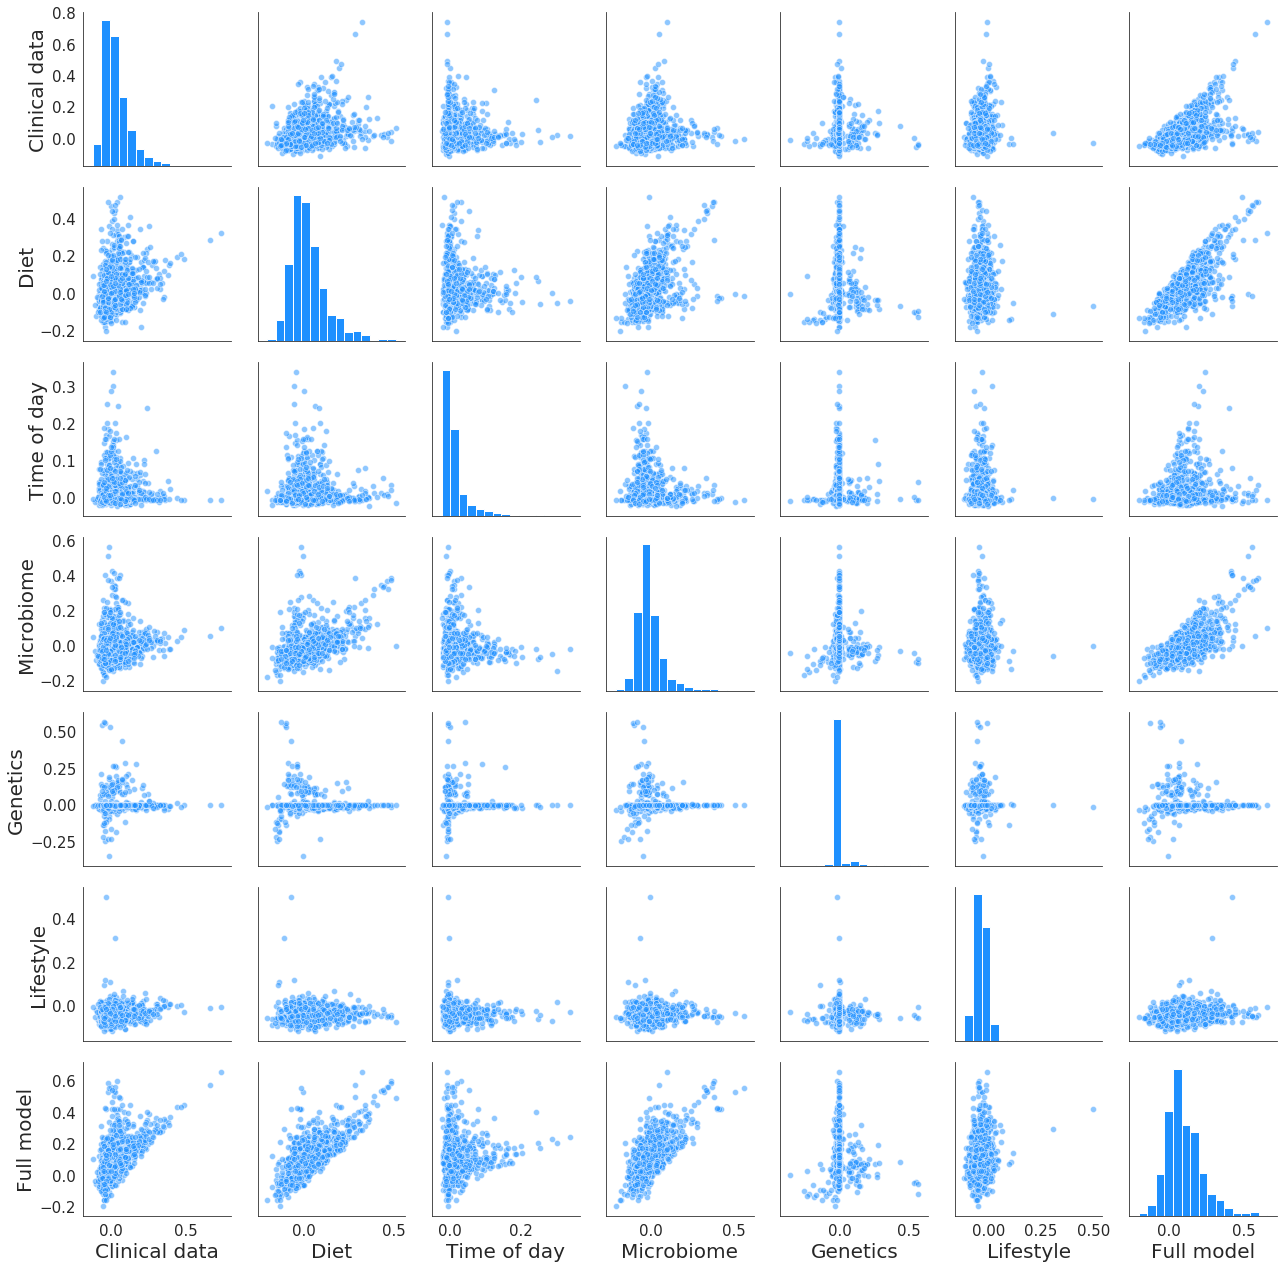

In [171]:
g = sns.pairplot(estimates_w_genetics, plot_kws={'color':'dodgerblue', 'alpha':0.5}, diag_kws={'color':'dodgerblue', 'edgecolor':'w', 'bins':15}, palette='dodgerblue') # diag_kind="kde" 'shade':True
for ax in g.axes.flatten():
    ax.tick_params(labelsize=15)
    ax.set_xlabel(ax.get_xlabel(), fontsize=20)
    ax.set_ylabel(ax.get_ylabel(), fontsize=20)
    
plt.savefig(os.path.join(curr_dir, '2Supp_pariplot_small.png'), dpi=200, bbox_inches='tight')
plt.savefig(os.path.join(curr_dir, '2Supp_pariplot.png'), dpi=1200, bbox_inches='tight')

### v2

In [258]:
estimates_w_genetics.to_csv(os.path.join(curr_dir, 'estimates_w_genetics.csv'))

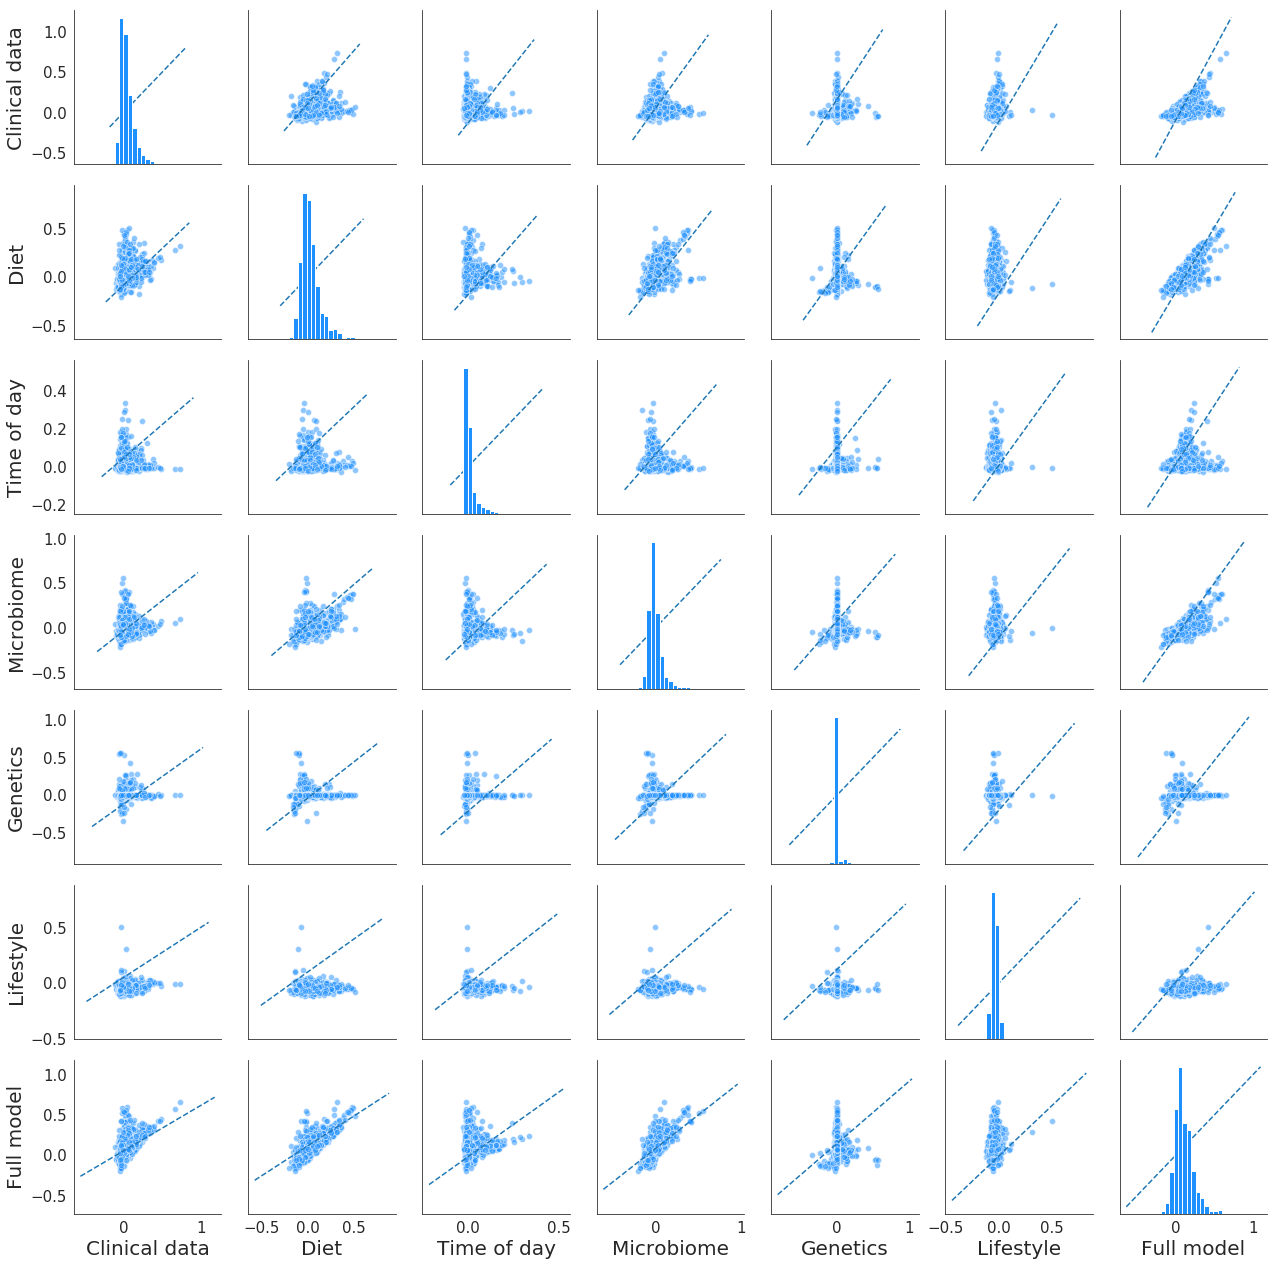

In [241]:
# run with seaborn 0.1.0

estimates_w_genetics = pd.read_csv('estimates_w_genetics.csv', index_col=0)

g = sns.pairplot(estimates_w_genetics, plot_kws={'color':'dodgerblue', 'alpha':0.5}, 
                 diag_kws={'color':'dodgerblue', 'edgecolor':'w', 'bins':15}, 
                 palette='dodgerblue', corner=True) # diag_kind="kde" 'shade':True
for ax in g.axes.flatten():
    if ax is not None:
        ax.tick_params(labelsize=15)
        ax.set_xlabel(ax.get_xlabel(), fontsize=20)
        ax.set_ylabel(ax.get_ylabel(), fontsize=20)
        
plt.savefig('Supp_figure3_pariplot_small.png', dpi=200, bbox_inches='tight')
plt.savefig('Supp_figure3_pariplot.png', dpi=1200, bbox_inches='tight')